In [40]:
from net import GPT
from sklearn.decomposition import PCA
import torch
import matplotlib.pyplot as plt

??GPT

Init signature: GPT(*args, **kwargs)
Docstring:      <no docstring>
Source:        
class GPT(BaseLayer):
    def __init__(self, n_embd, vocab_size, num_heads, num_blocks, block_size):
        super().__init__()
        self.n_embd = n_embd
        self.vocab_size = vocab_size
        self.num_heads = num_heads
        self.num_blocks = num_blocks
        self.block_size = block_size

        self.token_embeddings_table = Embedding(vocab_size, n_embd)
        self.pos_embeddings_table = Embedding(block_size, n_embd)
        self.blocks = Sequential(
            [
                DecoderTransformerBlock(num_heads, n_embd, context_length=block_size)
                for _ in range(num_blocks)
            ]
        )
        self.ln_f = LayerNorm(n_embd)
        self.ln_head = Linear(n_embd, vocab_size)

    def __call__(self, idx, targets=None):
        # inputs and targets are (B, T) shaped
        B, T = idx.shape

        tok_emb = self.token_embeddings_table(idx)  # (B, T, n_embd)
   

In [27]:
gpt = GPT(n_embd=32, vocab_size=16, num_heads=4, num_blocks=4, block_size=16)

gpt._collect_layers()

gpt._layers

baseline loss: tensor(2.7726)


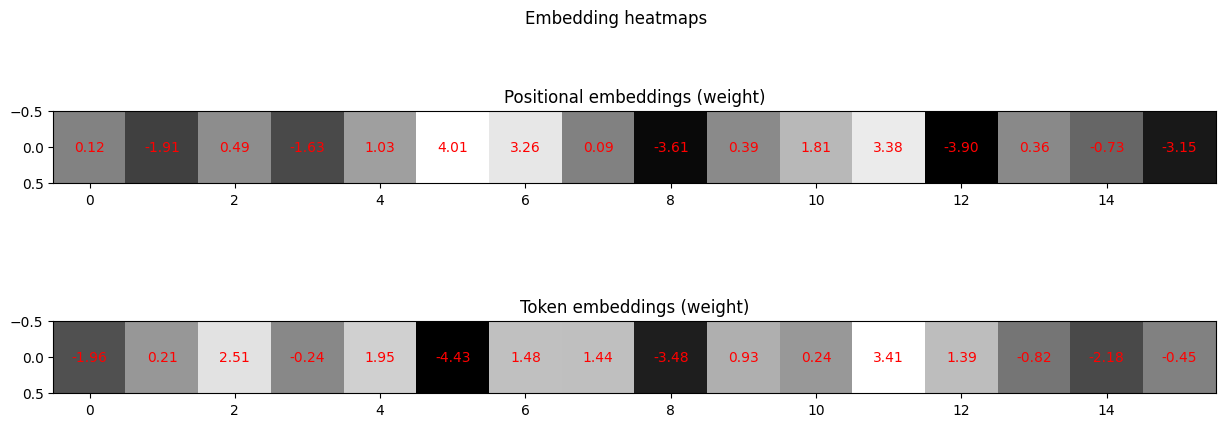

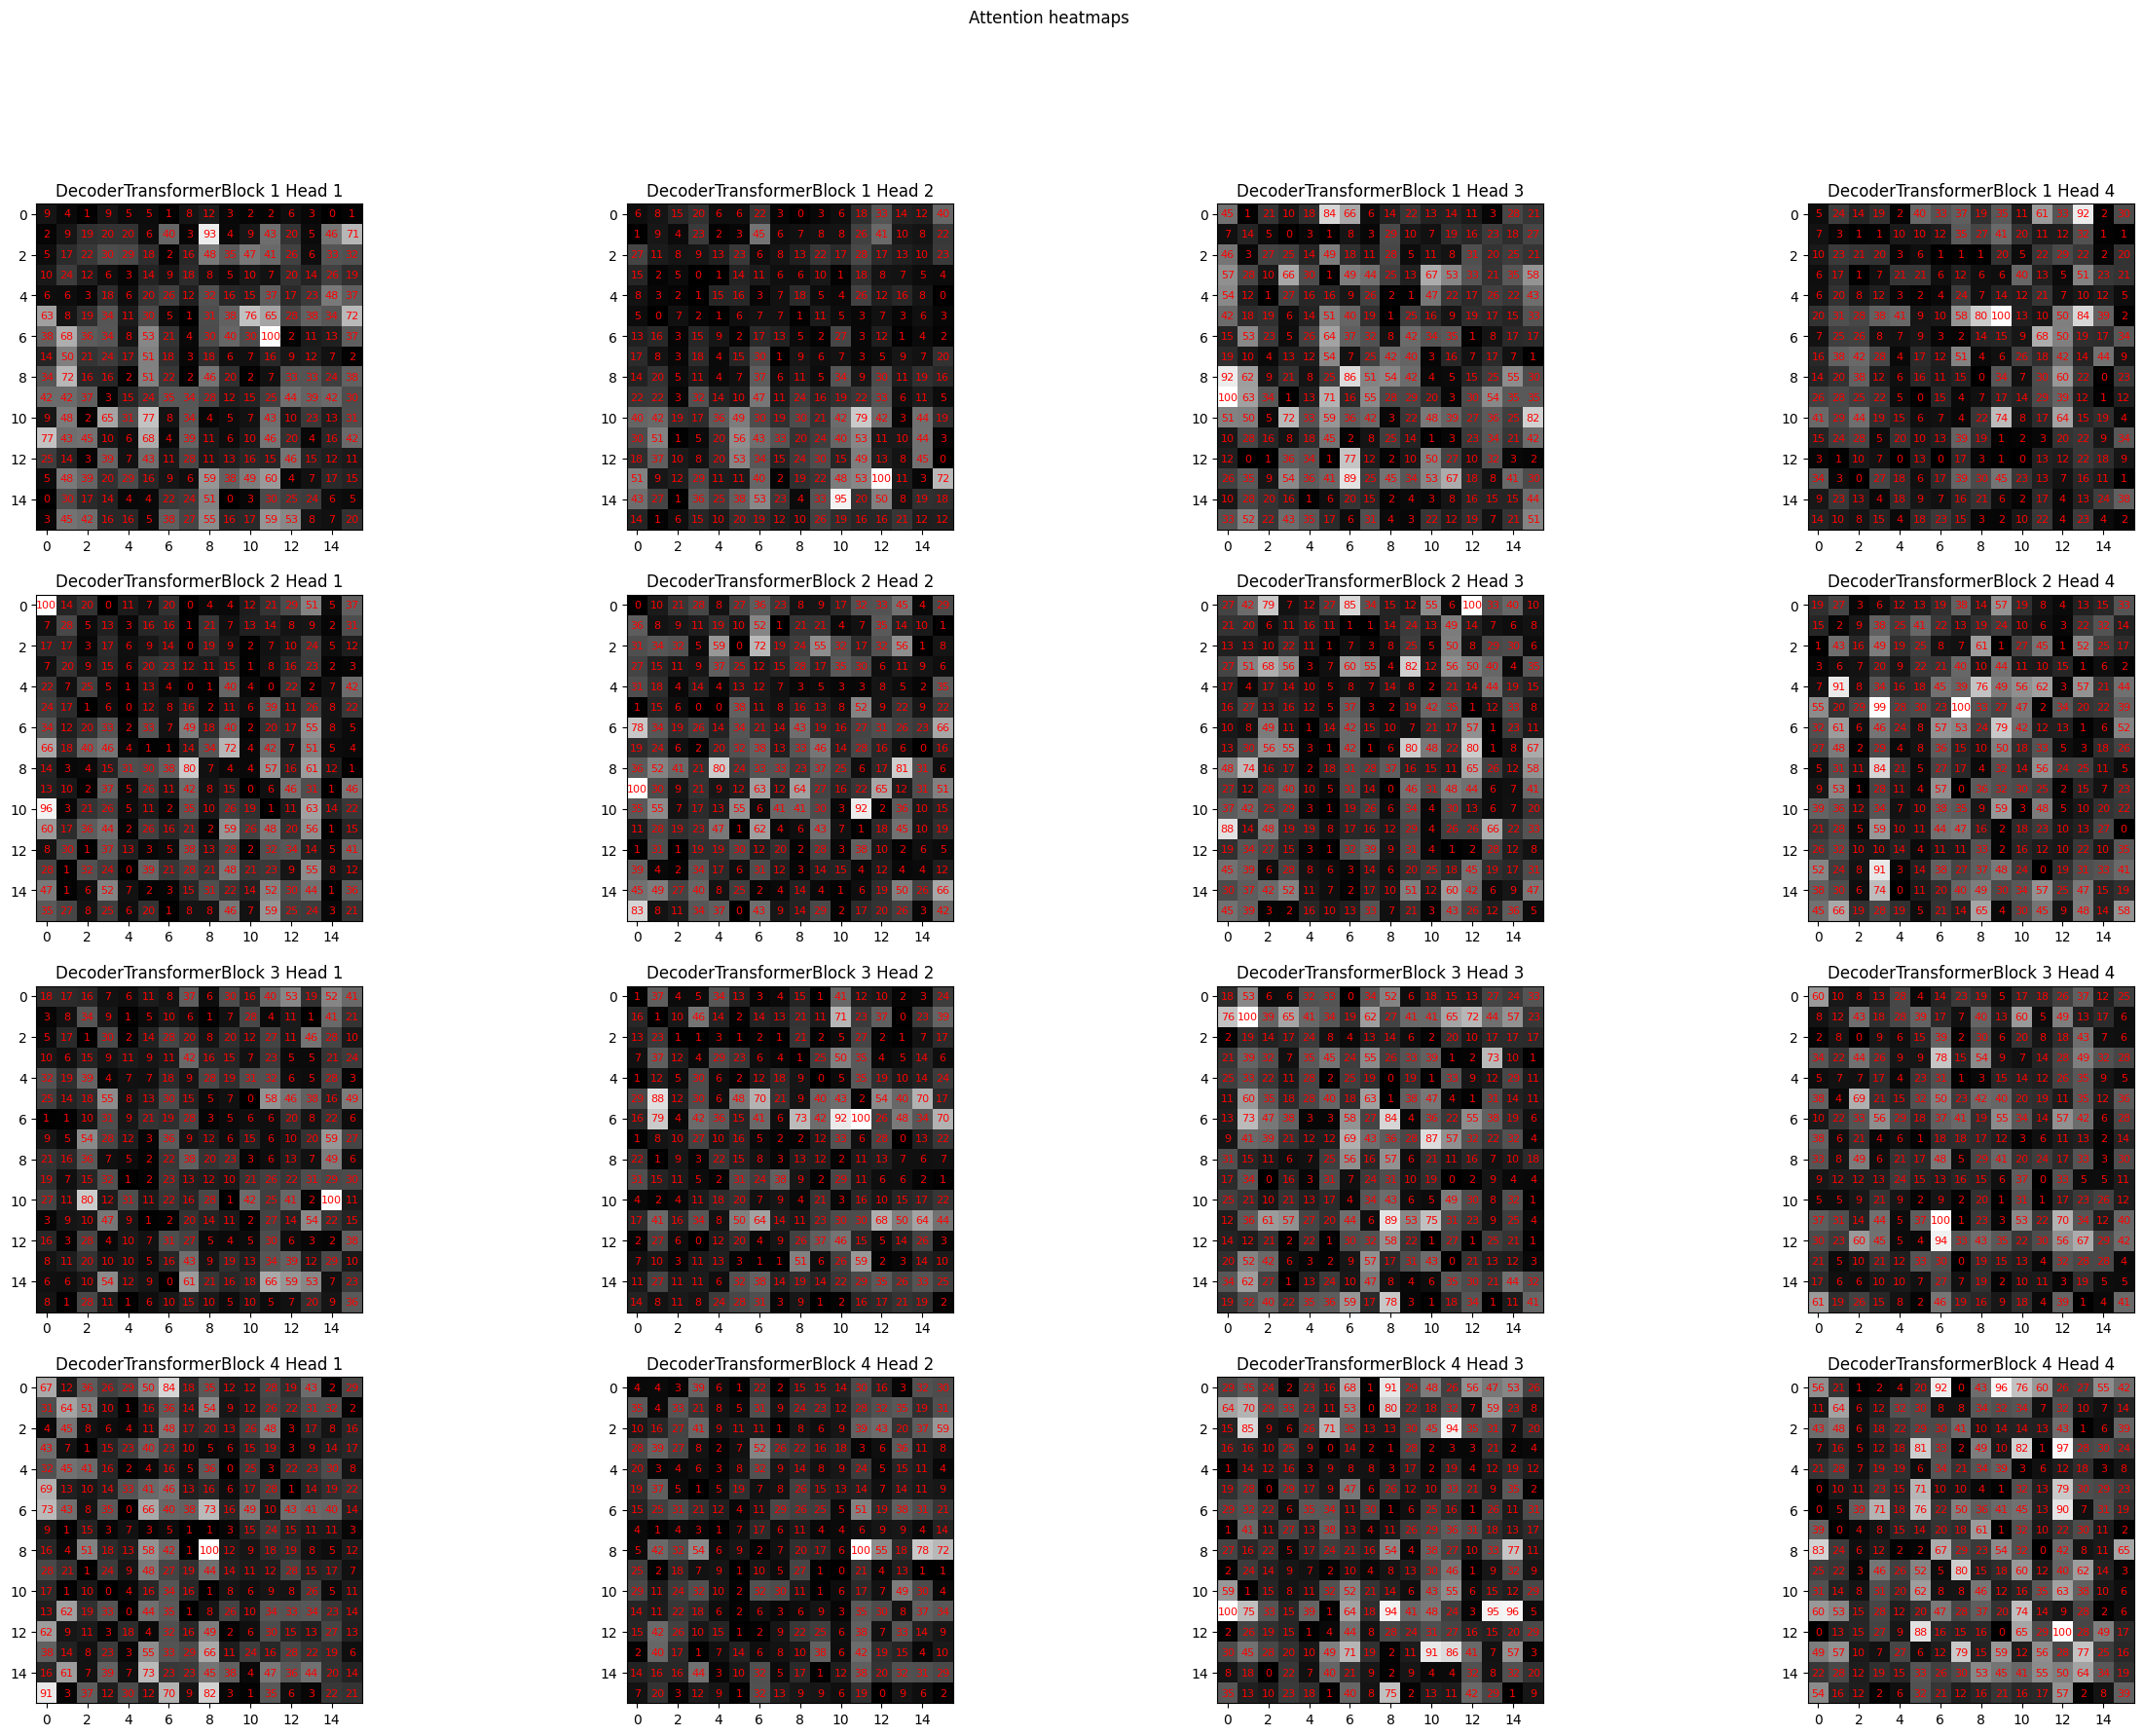

In [39]:
# TODO: a simple baseline where the probability of picking any token as the next token is uniform
# TODO: layer output distributions (histogram)
# TODO: layer output heatmap? to take a look at the absolute values of activations and stuff?
# TODO: loss graphs
# TODO: layer gradient means
# TODO: layer gradient stds
# TODO: ratio of amount of change in the parameters given the weights
#       we multiply the learning rate with the layer's gradient's std and divide it by
#       parameters' std. this ratio will be higher if gradient std is larger (grads vary too much from the mean)
#       and the params are smaller in comparison.
# TODO: layer output distributions (there's a ready-to-use function in lesson3 dev)
# TODO: layer grad distributions (there's a ready-to-use function in lesson3 dev)
# TODO: ratio of the gradient of a specific layer to its input
#       so if the ratio is too high, it means that the gradients are too high wtr to the input
#       and we actually want constant but smaller updates throughout the network to not miss any local minimas et.c
# TODO: ratio of the amount of change vs the weights, the stats should be saved in L7 here

# 1: Baseline
def get_baseline_score(model):
    """
    Calculate the baseline loss for the model.
    
    This function computes a baseline loss assuming uniform probability
    distribution over the vocabulary.

    Args:
    model: The GPT model instance

    Returns:
    float: The baseline loss
    """
    baseline_loss = -torch.log(torch.tensor(1/model.vocab_size))
    print("baseline loss:", baseline_loss)
    return baseline_loss

# 2: Layer output distributions as histograms (specific to the model)

def get_layer_output_histograms(model: GPT, sample_input: torch.Tensor = None):
    """
    Generate histograms of layer outputs for a given model.
    
    This function creates histograms for various layer outputs of the model,
    including embeddings, block outputs, and logits.

    Args:
    model (GPT): The GPT model instance
    sample_input (torch.Tensor, optional): Input tensor to use. If None, random input is generated.

    Returns:
    None. Displays the histograms using matplotlib.
    """ 
    if not sample_input:
        sample_input = torch.randint(0, model.vocab_size-1, (1, model.block_size), dtype=torch.long)
    layer_outputs = []
    # get the embeddings
    emb1 = model.token_embeddings_table(sample_input)
    # positional embeddings
    emb2 = model.pos_embeddings_table(torch.arange(model.block_size))
    # combine the embeddings
    emb = emb1 + emb2
    # pass the embeddings through the model
    block_outputs = model.blocks(emb)
    lnf_out = model.ln_f(block_outputs)
    logits = model.ln_head(lnf_out)

    # store the layer outputs and their titles
    layer_outputs = [emb1, emb2, emb, block_outputs, lnf_out, logits]
    plot_titles = ['Token embd', "Pos embd", "Combined emb", 
                'Block outputs', 'Layer norm', 'Language head'] 

    # generate 2x3 subplots
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))

    # set the plot titles and plot the layer outputs according to subplots
    for title, output, ax in zip(plot_titles, layer_outputs, axs.flatten()):
        ax.set_title(title)
        ax.hist(output.view(-1).tolist(), 50)
    plt.show()

    # now get into the decoder transformer blocks (dtb)
    out = emb
    for i, dtb in enumerate(model.blocks.layers):
        # get the outputs of the decoder transformer block
        first_ln = dtb.ln1(out) # layer norm
        self_attn_outs = dtb.self_attn(first_ln) # self attention
        first_res = out + self_attn_outs # residual connection
        second_ln = dtb.ln2(first_res) # layer norm
        mlp_outs = dtb.ffwd_net(second_ln) # feedforward network
        out = first_res + mlp_outs # second residual connection
        outputs = [first_ln, self_attn_outs, first_res, second_ln, mlp_outs, out]
        
        fig, axs = plt.subplots(2, 3, figsize=(15, 10))
        for title, output, ax in zip(plot_titles, outputs, axs.flatten()):
            ax.set_title(title)
            ax.hist(output.view(-1).tolist(), 50)
        
        fig.suptitle(f"DecoderTransformerBlock {i+1}")
        plt.show()

# 3: layer output heatmaps

# plot the heatmaps
# we'll use emb1, emb2 and emb

def plot_emb_weights(model: GPT, plot_text: bool = False):
    """
    Plot heatmaps of the embedding weights.
    
    This function creates heatmaps for positional and token embedding weights,
    applying PCA to reduce dimensionality if necessary.

    Args:
    model (GPT): The GPT model instance
    plot_text (bool, optional): If True, overlay weight values on the heatmap. Defaults to False.

    Returns:
    None. Displays the heatmaps using matplotlib.
    """
    fig, axs = plt.subplots(2, 1, figsize=(15, 5))
    weights = [model.pos_embeddings_table.weight, model.token_embeddings_table.weight]
    # apply PCA to the weights
    pca = PCA(n_components=1) # reduce to 1D
    # apply PCA to the weights
    weights = [pca.fit_transform(weight.detach().numpy()) for weight in weights]

    titles = ['Positional embeddings (weight)', 'Token embeddings (weight)']

    for title, weight, ax in zip(titles, weights, axs.flatten()):
        ax.set_title(title)
        ax.imshow(weight.T, cmap='gray', interpolation='nearest')
        if plot_text:
            for x in range(weight.shape[0]):
                for y in range(weight.shape[1]):
                    ax.text(x, y, f"{weight[x, y]:.2f}", color='red', ha='center', va='center')

    plt.suptitle("Embedding heatmaps")
    plt.show()

    # attention heatmaps
    # we'll use the attention heads' outputs from the decoder transformer blocks

def plot_attn_heatmaps(model: GPT, sample_input: torch.Tensor = None, plot_text: bool = False):
    """
    Plot heatmaps of attention weights for each layer and head.
    
    This function visualizes the attention weights for each attention head
    in each layer of the model.

    Args:
    model (GPT): The GPT model instance
    sample_input (torch.Tensor, optional): Input tensor to use. If None, random input is generated.
    plot_text (bool, optional): If True, overlay attention values on the heatmap. Defaults to False.

    Returns:
    None. Displays the heatmaps using matplotlib.
    """
    if not sample_input:
        sample_input = torch.randint(0, model.vocab_size-1, (1, model.block_size), dtype=torch.long)
    model(sample_input);

    attention_outputs = []
    for i, dtb in enumerate(gpt.blocks.layers):
        dtb_attn_out = []
        # get the attention weights for each head
        for j, attn_head in enumerate(dtb.self_attn.heads):
            # get the query and key outputs
            q = attn_head.query.out
            k = attn_head.key.out
            w = (q @ k.transpose(-2, -1)) * (attn_head.head_size**-.5) # calculate the attention weights
            # append the attention weights to the list
            dtb_attn_out.append(w[0]) # (1, T, T)
        attention_outputs.append(dtb_attn_out)

    # plot the heatmaps
    font_size = 2*model.num_heads
    figsize = (int(7.5 * model.num_heads), int(5 * model.num_heads))

    fig, axs = plt.subplots(len(gpt.blocks.layers), gpt.num_heads, figsize=figsize)
    for i, dtb_attn_out in enumerate(attention_outputs):
        for j, attn_head_out in enumerate(dtb_attn_out):
            # normalize the attention weights
            plot_data = attn_head_out.detach().abs()
            plot_data /= plot_data.max()
            # plot the heatmap
            axs[i, j].imshow(plot_data.numpy(), cmap='gray', interpolation='nearest')
            axs[i, j].set_title(f"DecoderTransformerBlock {i+1} Head {j+1}")
            # text annotations
            if plot_text:
                for x in range(plot_data.size(0)):
                    for y in range(plot_data.size(1)):
                        axs[i, j].text(y, x, f"{plot_data[x, y] * 100:.0f}", color='red', ha='center', va='center', fontsize=font_size)

    plt.suptitle("Attention heatmaps")
    plt.show()

get_baseline_score(gpt)
get_layer_output_histograms(gpt)
plot_emb_weights(gpt, plot_text=True)
plot_attn_heatmaps(gpt, plot_text=True)